# Capstone 2 on RDU Airline Delays - Modeling2
10/19/22

We have wrangled, explored, and preprocessed our data. Now let's create some models to predict whether or not a flight will be delayed/cancelled. (This is attempt 2 because I realized an issue with my dataset.)

In [1]:
#Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset

X_train = pd.read_csv('X_train2.csv')
X_test = pd.read_csv('X_test2.csv')
y_train = pd.read_csv('y_train2.csv')
y_test = pd.read_csv('y_test2.csv')

In [3]:
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0'], axis=1, inplace=True)
y_train.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
X_train.columns

Index(['FL_NUM', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4', 'MONTH_2', 'MONTH_3',
       'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       ...
       'DEST_TTN', 'DEST_VPS', 'DEP_TIME_BINS_LATE_NIGHT',
       'DEP_TIME_BINS_MIDDAY', 'DEP_TIME_BINS_MORNING',
       'ARR_TIME_BINS_LATE_NIGHT', 'ARR_TIME_BINS_MIDDAY',
       'ARR_TIME_BINS_MORNING', 'CRS_ELAPSED_TIME_LG', 'DISTANCE_LG'],
      dtype='object', length=124)

In [5]:
y_train = pd.DataFrame(y_train).to_numpy().ravel()
y_test = pd.DataFrame(y_test).to_numpy().ravel()

It's hard to remember now what my columns are, so here's the list of columns before get_dummies:

         QUARTER              52645 non-null  category
         MONTH                52645 non-null  category
         DAY_OF_MONTH         52645 non-null  category
         DAY_OF_WEEK          52645 non-null  category
         CARRIER              52645 non-null  object  
         FL_NUM               52645 non-null  object  
         DEST                 52645 non-null  object  
         CRS_ELAPSED_TIME_LG  52645 non-null  float64 
         DISTANCE_LG          52645 non-null  float64
         DEP_TIME_BINS        52645 non-null  object  
         ARR_TIME_BINS        52626 non-null  object  

And this is what our RESULT column corresponds to:

                0 = no delay
                1 = delay of 1 hour or less
                2 = delay of 2 hours or less
                3 = delay of more than 2 hours
                4 = cancelled

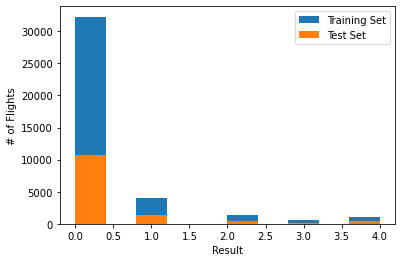

In [6]:
fig, ax = plt.subplots()
ax.hist(y_train, label="Training Set")
ax.hist(y_test, label="Test Set")
ax.set_xlabel('Result')
ax.set_ylabel('# of Flights')
ax.legend()
plt.show()

In [7]:
print(np.unique(y_train, return_counts=True))      # about 32k flights with no delay, about 7k with delay/cancellation
print(np.unique(y_test, return_counts=True))      # about 11k flights with no delay, about 2.5k with delay/cancellation

(array([0, 1, 2, 3, 4], dtype=int64), array([32275,  4096,  1428,   571,  1113], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([10661,  1446,   470,   198,   387], dtype=int64))


As we can see, there are way more Result=0 (no delay) than any other category. We'll need to take this extremely skewed result column into account when evaluating our models. We could have a relatively high accuracy score, but a poor result.

## Scaling our data

We've preprocessed/scaled individual features, but now we'll scale our whole X dataset.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Models

Since we're trying to solve a multiclass classification problem, we can use the following models:

        0. Dummy Classifier
        1. KNN Classifier
        2. Extra Trees Classifier
        3. Random Forest Classifier
        4. Support Vector Machine Classifier
        5. Gradient Boosting Classifier
        
We've already done our preprocessing/scaling and standardizing. We'll perform cross validation with KFold, hyperparameter tuning with RandomizedSearchCV, and put these together with a pipeline.

## 0. Dummy Classifier

The sklearn dummy classifier will give us a baseline with which to compare.

In [7]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)

print("Accuracy Score on Training Set for Dummy Classifier: {}".format(dummy_clf.score(X_train_scaled, y_train)))
print("Accuracy Score on Test Set for Dummy Classifier: {}".format(dummy_clf.score(X_test_scaled, y_test)))

Accuracy Score on Training Set for Dummy Classifier: 0.8174404173948282
Accuracy Score on Test Set for Dummy Classifier: 0.809983285215013


In [8]:
y_pred_dummy = dummy_clf.predict(X_test_scaled)
y_probs_dummy = dummy_clf.predict_proba(X_test_scaled)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy Score on Test Set for Dummy Classifier: {}"
      .format(accuracy_score(y_test, y_pred_dummy)))
print("Precision Score - weighted averaged on Test Set for Dummy Classifier: {}"
      .format(precision_score(y_test, y_pred_dummy, average='weighted')))
print("Recall Score - weighted averaged on Test Set for Dummy Classifier: {}"
      .format(recall_score(y_test, y_pred_dummy, average='weighted')))
print("F1 Score - weighted averaged on Test Set for Dummy Classifier: {}"
      .format(f1_score(y_test, y_pred_dummy, average='weighted')))
print("ROC-AUC score - weighted averaged on Test Set for Dummy Classifier: {}"
      .format(roc_auc_score(y_test, y_probs_dummy, average='weighted', multi_class='ovo')))

# note: since my dataset is imbalanced, I'm using average=weighted

Accuracy Score on Test Set for Dummy Classifier: 0.809983285215013
Precision Score - weighted averaged on Test Set for Dummy Classifier: 0.6560729223277049
Recall Score - weighted averaged on Test Set for Dummy Classifier: 0.809983285215013
F1 Score - weighted averaged on Test Set for Dummy Classifier: 0.7249491502898252
ROC-AUC score - weighted averaged on Test Set for Dummy Classifier: 0.5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see, we have a decent accuracy score just for the dummy classifier: 81%! But since we have an imbalanced dataset, this doesn't mean too much. The other netrics will be more important.

## 1. K Nearest Neighbors

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
params = {"n_neighbors": np.arange(1, 50, 2),
        "weights": ['uniform', 'distance'],
         'p': [1, 2],}
knn_cv = RandomizedSearchCV(knn, params, cv=5)
knn_cv.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']})

In [12]:
print("Tuned KNN Classifier Parameters: {}".format(knn_cv.best_params_))
print("Tuned KNN Classifier Best Accuracy Score: {}".format(knn_cv.best_score_))

Tuned KNN Classifier Parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 27}
Tuned KNN Classifier Best Accuracy Score: 0.8175670156250583


Let's calculate some metrics for this KNN classifier: accuracy, precision, and ROC-AUC score.

In [13]:
y_pred_knn = knn_cv.predict(X_test_scaled)
y_probs_knn = knn_cv.predict_proba(X_test_scaled)

In [14]:
print("Accuracy Score on Test Set for KNN Classifier: {}"
      .format(accuracy_score(y_test, y_pred_knn)))
print("Precision Score - weighted averaged on Test Set for KNN Classifier: {}"
      .format(precision_score(y_test, y_pred_knn, average='weighted')))
print("Recall Score - weighted averaged on Test Set for KNN Classifier: {}"
      .format(recall_score(y_test, y_pred_knn, average='weighted')))
print("F1 Score - weighted averaged on Test Set for KNN Classifier: {}"
      .format(f1_score(y_test, y_pred_knn, average='weighted')))
print("ROC-AUC score - weighted averaged on Test Set for KNN Classifier: {}"
      .format(roc_auc_score(y_test, y_probs_knn, average='weighted', multi_class='ovo')))

Accuracy Score on Test Set for KNN Classifier: 0.8097553563288254
Precision Score - weighted averaged on Test Set for KNN Classifier: 0.7054952846412487
Recall Score - weighted averaged on Test Set for KNN Classifier: 0.8097553563288254
F1 Score - weighted averaged on Test Set for KNN Classifier: 0.7292873332824145
ROC-AUC score - weighted averaged on Test Set for KNN Classifier: 0.6342929995837852


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Extra Trees Classifier

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
ETC = ExtraTreesClassifier()
params = {"n_estimators": np.arange(25, 500, 25),
        "criterion": ["gini", "entropy"],
          "max_features": ['auto', 'sqrt']}
ETC_cv = RandomizedSearchCV(ETC, params, cv=5)
ETC_cv.fit(X_train_scaled, y_train) 

RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
       350, 375, 400, 425, 450, 475])})

In [16]:
print("Tuned Extra Trees Classifier Parameters: {}".format(ETC_cv.best_params_))
print("Tuned Extra Trees Classifier Best Accuracy Score: {}".format(ETC_cv.best_score_))

Tuned Extra Trees Classifier Parameters: {'n_estimators': 325, 'max_features': 'sqrt', 'criterion': 'gini'}
Tuned Extra Trees Classifier Best Accuracy Score: 0.8012563028115662


In [17]:
y_pred_etc = ETC_cv.predict(X_test_scaled)
y_probs_etc = ETC_cv.predict_proba(X_test_scaled)

In [18]:
print("Accuracy Score on Test Set for Extra Trees Classifier: {}"
      .format(accuracy_score(y_test, y_pred_etc)))
print("Precision Score - weighted averaged on Test Set for Extra Trees Classifier: {}"
      .format(precision_score(y_test, y_pred_etc, average='weighted')))
print("Recall Score - weighted averaged on Test Set for Extra Trees Classifier: {}"
      .format(recall_score(y_test, y_pred_etc, average='weighted')))
print("F1 Score - weighted averaged on Test Set for Extra Trees Classifier: {}"
      .format(f1_score(y_test, y_pred_etc, average='weighted')))
print("ROC-AUC score - weighted averaged on Test Set for Extra Trees Classifier: {}"
      .format(roc_auc_score(y_test, y_probs_etc, average='weighted', multi_class='ovo')))

Accuracy Score on Test Set for Extra Trees Classifier: 0.7935724054095122
Precision Score - weighted averaged on Test Set for Extra Trees Classifier: 0.7138153223322858
Recall Score - weighted averaged on Test Set for Extra Trees Classifier: 0.7935724054095122
F1 Score - weighted averaged on Test Set for Extra Trees Classifier: 0.7416845566255036
ROC-AUC score - weighted averaged on Test Set for Extra Trees Classifier: 0.6896261138845269


## 3. Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
params = {"n_estimators": np.arange(25, 500, 25),
        "criterion": ["gini", "entropy"],
          "max_features": ['auto', 'sqrt']}
RF_cv = RandomizedSearchCV(RF, params, cv=5)
RF_cv.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
       350, 375, 400, 425, 450, 475])})

In [20]:
print("Tuned Random Forest Classifier Parameters: {}".format(RF_cv.best_params_))
print("Tuned Random Forest Classifier Best Accuracy Score: {}".format(RF_cv.best_score_))

Tuned Random Forest Classifier Parameters: {'n_estimators': 450, 'max_features': 'auto', 'criterion': 'entropy'}
Tuned Random Forest Classifier Best Accuracy Score: 0.8117418135136283


In [21]:
y_pred_rf = RF_cv.predict(X_test_scaled)
y_probs_rf = RF_cv.predict_proba(X_test_scaled)

In [22]:
print("Accuracy Score on Test Set for Random Forest Classifier: {}"
      .format(accuracy_score(y_test, y_pred_rf)))
print("Precision Score - weighted averaged on Test Set for Random Forest Classifier: {}"
      .format(precision_score(y_test, y_pred_rf, average='weighted')))
print("Recall Score - weighted averaged on Test Set for Random Forest Classifier: {}"
      .format(recall_score(y_test, y_pred_rf, average='weighted')))
print("F1 Score - weighted averaged on Test Set for Random Forest Classifier: {}"
      .format(f1_score(y_test, y_pred_rf, average='weighted')))
print("ROC-AUC score - weighted averaged on Test Set for Random Forest Classifier: {}"
      .format(roc_auc_score(y_test, y_probs_rf, average='weighted', multi_class='ovo')))

Accuracy Score on Test Set for Random Forest Classifier: 0.8036012764017626
Precision Score - weighted averaged on Test Set for Random Forest Classifier: 0.7139055523460799
Recall Score - weighted averaged on Test Set for Random Forest Classifier: 0.8036012764017626
F1 Score - weighted averaged on Test Set for Random Forest Classifier: 0.738135686608513
ROC-AUC score - weighted averaged on Test Set for Random Forest Classifier: 0.6975835318369625


## 4. Support Vector Machine Classifier

In [ ]:
from sklearn.svm import SVC
SVC = SVC()
SVC.fit(X_train_scaled, y_train)
y_pred_svc = SVC.predict(X_test_scaled)
y_probs_svc = SVC.predict_proba(X_test_scaled)

In [ ]:
from sklearn.svm import SVC
SVC = SVC()
params = {'C': [0.1, 1, 10, 100, 1000], 
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['linear', 'rbf', 'poly']}
SVC_cv = RandomizedSearchCV(SVC, params, cv=5)
SVC_cv.fit(X_train_scaled, y_train)

In [ ]:
print("Tuned Support Vector Classifier Parameters: {}".format(SVC_cv.best_params_))
print("Tuned Support Vector Classifier Best Accuracy Score: {}".format(SVC_cv.best_score_))

In [ ]:
y_pred_svc = SVC_cv.predict(X_test_scaled)
y_probs_svc = SVC_cv.predict_proba(X_test_scaled)

In [ ]:
print("Accuracy Score on Test Set for Support Vector Classifier: {}"
      .format(accuracy_score(y_test, y_pred_svc)))
print("Precision Score - weighted averaged on Test Set for Support Vector Classifier: {}"
      .format(precision_score(y_test, y_pred_svc, average='weighted')))
print("Recall Score - weighted averaged on Test Set for Support Vector Classifier: {}"
      .format(recall_score(y_test, y_pred_svc, average='weighted')))
print("F1 Score - weighted averaged on Test Set for Support Vector Classifier: {}"
      .format(f1_score(y_test, y_pred_svc, average='weighted')))
print("ROC-AUC score - weighted averaged on Test Set for Support Vector Classifier: {}"
      .format(roc_auc_score(y_test, y_probs_svc, average='weighted', multi_class='ovo')))

## 5. Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier()
params = {"n_estimators":[5,50,250,500],
          "max_depth":[1,3,5,7,9], 
          "learning_rate":[0.01,0.1,1,10,100]}
GBC_cv = RandomizedSearchCV(GBC, params, cv=5)
GBC_cv.fit(X_train_scaled, y_train)

In [ ]:
print("Tuned Gradient Boosting Classifier Parameters: {}".format(GBC_cv.best_params_))
print("Tuned Gradient Boosting Classifier Best Accuracy Score: {}".format(GBC_cv.best_score_))

In [ ]:
y_pred_gbc = GBC_cv.predict(X_test_scaled)
y_probs_gbc = GBC_cv.predict_proba(X_test_scaled)

In [ ]:
print("Accuracy Score on Test Set for Gradient Boosting Classifier: {}"
      .format(accuracy_score(y_test, y_pred_gbc)))
print("Precision Score - weighted averaged on Test Set for Gradient Boosting Classifier: {}"
      .format(precision_score(y_test, y_pred_gbc, average='weighted')))
print("Recall Score - weighted averaged on Test Set for Gradient Boosting Classifier: {}"
      .format(recall_score(y_test, y_pred_gbc, average='weighted')))
print("F1 Score - weighted averaged on Test Set for Gradient Boosting Classifier: {}"
      .format(f1_score(y_test, y_pred_gbc, average='weighted')))
print("ROC-AUC score - weighted averaged on Test Set for Gradient Boosting Classifier: {}"
      .format(roc_auc_score(y_test, y_probs_gbc, average='weighted', multi_class='ovo')))

## Conclusion

In both cases, the Random Forest Classifier outperforms the KNN Classifier. 

For the RF Classifier we can use the hyperparameters found through RandomizedSearchCV: {'n_estimators': 200, 'max_features': 'auto', 'criterion': 'gini'}.

Surprisingly the accuracy on the test set is quite good, even a tiny bit higher than the train set at 0.85.